# NOI: Zufallsprozesse und Quantisierung im Frequenzbereich #
## Quantisierung und Wahrscheinlichkeitsdichte ##

Dieses Notebook zeigt den Einfluss verschiedener Quantisierungs- und Überlaufsoptionen auf die Wahrscheinlichkeitsdichtefunktion des Rauschens.

In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

#%matplotlib notebook
%matplotlib inline
import dsp_fpga_lib as dsp # import and set plot properties
import dsp_fpga_fix_lib as fx

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import numpy as np
from numpy import sin, cos, pi, arange, log10, zeros, linspace, ones, sqrt
from scipy.stats import norm
import scipy.signal as sig

figsize = {"figsize":(15,10)}

In [2]:
N = 10000 # number of data points
t = linspace(0, 1, N, endpoint=False) # time vector
N_bins = 51 # number of bins for probability density function
# ------ Signals ------------ 
A = 0.9 # amplitude or scale factor
x = A * sin(2*pi*t*3)
x = A * np.random.rand(N) # gleichverteiltes Rauschen
#x = A * np.random.randn(N) # normalverteiltes (Gaussches) Rauschen
# ---- Define quantizer and quantize signal -----------------
q_obj = {'WI':0, 'WF': 4, 'quant':'floor', 'ovfl': 'sat'} # try 'round' ; 'sat'
Q1 = fx.Fixed(q_obj)
x_q = Q1.fixp(x) # quantize x
x_eps = x - x_q # quantization error

Durch das Einkommentieren der Option `%matplotlib notebook` anstatt `%matplotlib inline` in der ersten Zelle erhalten Sie einen interaktiven Plot (mit gewissen Einschränkungen, funktioniert momentan nicht mit JupyterLab).

Im folgenden Plot finden Sie

- die Quantisierungskennlinie $x_q(x)$
- Signal $x(t)$, quantisiertes Signal $x_q(t)$ und Quantisierungsfehler $x_\epsilon(t) = x(t) - x_q(t)$ als Zeitsignal
- die zugehörigen Verteilungsdichtefunktionen $p(x)$, $p({x_q})$ und $p({x_\epsilon})$, die beschreiben mit welcher Wahrscheinlichkeit die Variablen sich in einem bestimmten Wertebereich befinden.

Das Integral der Wahrscheinlichkeitsdichtefunktion $p$ zwischen den Grenzen $x_1$ und $x_2$ beschreibt die Wahrscheinlichkeit, mit der der Wert der Variablen $x$ zwischen diesen Grenzen liegt:

\begin{equation}
\int_{x_1}^{x_2} p(x) dx = Pr(x_1 < x \le x_2)
\end{equation}

Da $x$ bei einem "normalen" Signal einen Wert im Bereich $]-\infty, \infty[$ haben muss, gilt natürlich:

\begin{equation}
\int_{-\infty}^{\infty} p(x) dx = 1
\end{equation}

Bei diskreten Folgen kann man auch die Anzahl der Werte $N$ pro Bin auftragen.


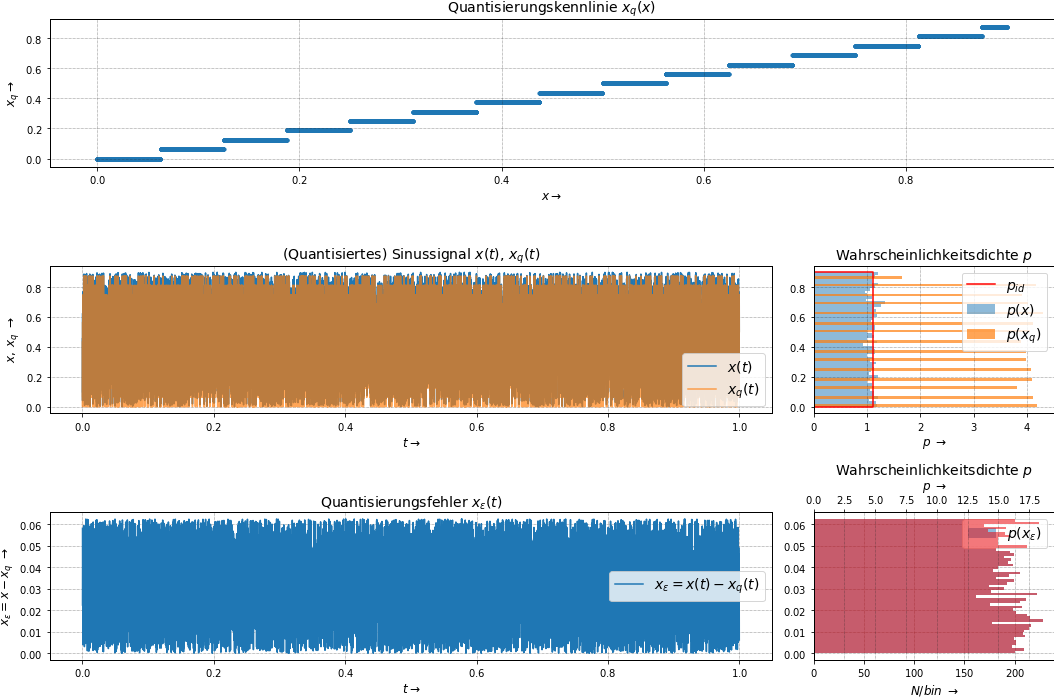

In [12]:
fig1 = plt.figure(1, **figsize)
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1]) 
ax10 = plt.subplot(gs[0,:])
ax10.set_title('Quantisierungskennlinie $x_q(x)$')
#ax10.step(x,x_q, where = 'post')
ax10.scatter(x,x_q, s=10)
ax10.set_xlabel(r'$x \rightarrow$')
ax10.set_ylabel(r'$x_q \rightarrow$');
ax11 = plt.subplot(gs[1,0])
ax11.set_title('(Quantisiertes) Sinussignal $x(t)$, $x_q(t)$')
ax11.plot(t, x, label = r'$x(t)$')
ax11.plot(t, x_q, label = r'$x_q(t)$', alpha=0.7)
ax11.legend(fontsize = 14)
ax11.set_xlabel(r'$t \rightarrow$'); ax11.set_ylabel(r'$x, \;x_q \; \rightarrow$')
ax12= plt.subplot(gs[1,1])
ax12.set_title("Wahrscheinlichkeitsdichte $p$")
ax12.hist(x, bins=N_bins,  
                       density=True, # True: probability density, False: absolute Zahlen
                       weights=None, cumulative=False, bottom=None, histtype=u'bar', 
                       align=u'mid', orientation=u'horizontal', rwidth=None, log=False, 
                       color=None, alpha=0.5, label='$p(x)$', stacked=False)
ax12.hist(x_q, bins=N_bins,  
                       density=True, # True: probability density, False: absolute Zahlen
                       weights=None, cumulative=False, bottom=None, histtype=u'bar', 
                       align=u'mid', orientation=u'horizontal', rwidth=None, log=False, 
                       color=None, alpha=0.7, label='$p(x_q)$', stacked=False)
ax12.plot([0, 1/(x.max()-x.min()), 1/(x.max()-x.min()), 0],[x.min(),x.min(),x.max(),x.max()], 
          'r-', label='$p_{id}$')# ideale pdf für gleichverteilte Variable
ax12.legend(fontsize = 14)
ax12.set_xlabel(r"$p\;\rightarrow$")
ax13 = plt.subplot(gs[2,0])
ax13.set_title('Quantisierungsfehler $x_\epsilon(t)$')
ax13.plot(t, x_eps, label = r'$x_{\epsilon} = x(t) - x_q(t)$')
ax13.set_ylabel(r'$x_{\epsilon} = x - x_q \; \rightarrow$')
ax13.legend(fontsize = 14)
ax13.set_xlabel(r'$t \rightarrow$');
#
ax14 = plt.subplot(gs[2,1])
ax14.set_title("Wahrscheinlichkeitsdichte $p$")
ax14.hist(x_eps, bins=N_bins, 
            #range=(0, Q1.LSB), 
            density=False, weights=None, cumulative=False, bottom=None, histtype=u'bar', 
            align=u'mid', orientation=u'horizontal', rwidth=None, log=False, 
            color=None, alpha=0.5, label='$p(x_\epsilon}$)', stacked=False)
ax14.set_xlabel(r"$N/bin \;\rightarrow$")
ax14.legend(fontsize = 14)
ax15 = ax14.twiny()
ax15.hist(x_eps, bins=N_bins, 
            #range=(0, Q1.LSB), 
            density=True, weights=None, cumulative=False, bottom=None, histtype=u'bar', 
            align=u'mid', orientation=u'horizontal', rwidth=None, log=False, 
            color='red', alpha=0.5, label='$p(x_\epsilon}$)', stacked=False)
ax15.set_xlabel(r"$p\;\rightarrow$")
fig1.tight_layout()

### Fragen und Experimente
- Können Sie aus der Quantisierungskennlinie erkennen, welche Art der Requantisierung und ob Sättigungslogik verwendet wurde? Und aus dem Plot des quantisierten Signals?
- Warum ist die Wahrscheinlichkeitsdichte bei Übersteuerung alles andere als gleichverteilt? Warum ist das auch bei wenigen Bits Wortlänge so?
- Überprüfen Sie (durch "Hingucken") dass das Integral von $p$ über den gesamten Wertebereich 1 ist. Das geht am einfachsten mit einer konstanten Wahrscheinlichkeitsdichtefunktion, z.B. für ein gleichverteiltes Zufallssignal.
- Was ist der Unterschied zwischen der Anzahl $N$ der Werte pro Bin und der Wahrscheinlichkeitsdichtefunktion $p$ im letzten Plot?
- Was passiert, wenn Sie den Quantisierer übersteuern? Vergleichen Sie die Optionen `'sat'` und `'wrap'`.
- Warum verschwindet bei Übersteuerung und N_bin = 50 oder 60 die pdf an der unteren oder oberen Grenze (ich verstehe auch nicht warum, ein Darstellungsfehler?)
- Spielen Sie mit dem Skript herum, ändern Sie das Eingangssignal und die Quantisierungseinstellungen und versuchen Sie den Code (ggf. mit Hilfe der Hinweise im vorigen Kapitel) nachzuvollziehen.


***
### Copyright

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources), feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2019*.